In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
def fn_plot_torch_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas DataFrame with five columns
                First column need to be epoch, 'x' values
                Second and third columns are losses
                fourth and fifth columns are accuracies
    '''
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor=facecolor, alpha=0.5)
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()].head(1) # head one, just incase of multiple lines

    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1,y2], ax = ax)

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, 
            transform=ax.transAxes, 
            fontsize=fontsize,
            verticalalignment='top', 
            bbox=props)
    
    # Mark arrow at lowest
    offset = (best[y2].max() - best[y2].max())/10
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()-2, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left
    ax.grid(True)
    
    # pick second axis
    ax = axes[1]

    # Plot accuracy
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, 
            transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    offset = (best[y4].max() - best[y4].min())/10
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()-2, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y3.capitalize())
    ax.set_title('Accuracies')
    ax.legend(loc = 'lower left')
    ax.grid(True)
    plt.tight_layout()

def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictionary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (4,4))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show()

In [3]:
altName = 'all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
BATCH_SIZE = 32 # batch size for training   
TRAIN_SIZE = BATCH_SIZE * 9
WEIGHT_DECAY = 0.001

EPOCHS = 100 # number of cycles to run
ALPHA = 0.001 # learning rate
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
data_df = pd.read_csv('ionosphere.data', header=None)
data_df.shape

(351, 35)

In [5]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [6]:
train_df, test_df = train_test_split(data_df, train_size = TRAIN_SIZE, 
                                    stratify = data_df[data_df.columns[-1]], random_state=RANDOM_STATE)
train_df.shape, test_df.shape

((288, 35), (63, 35))

In [7]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
'''Using Singleton design pattern'''

class Transformers:
    _instance = None
    
    def __init__(self):
        if Transformers._instance is not None:
            raise Exception ("Global Scaler class is a singleton")
        
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = Transformers()
        return cls._instance

In [9]:
'''In ths code we define a custom dataset called IonoDS that takes a Dataframe'''\
    
class IonoDS(Dataset):
    transformers = Transformers.get_instance() # private instance variable
    
    def __init__(self, 
                 dataframe: pd.DataFrame,
                 device: str = device,
                 is_train = True,
                 label_col = None):
        super(IonoDS, self).__init__()
        
        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.scaler = self.transformers.scaler
        self.encoder = self.transformers.encoder
        self.label_col = label_col
        
        y = self.df[label_col].to_numpy()
        X = self.df.drop(label_col, axis=1)
        
        if self.is_train:
            self.labels = self.encoder.fit_transform(y)
            self.features = self.scaler.fit_transform(X) # fit transform train set
        else:
            self.labels = self.encoder.transform(y)
            self.features = self.scaler.transform(X) # transform only test set
            
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32, device=self.device)
        label = torch.tensor(label, dtype=torch.int64, device=self.device)
        
        return features, label

In [10]:
class Model(nn.Module):
    
    def __init__(self, input_dim):
        
        super(Model, self).__init__()
        
        dor1 = 0.05
        dor2 = 0.15
        dor3 = 0.25
        
        ## Set 1
        self.layer1 = nn.Linear(input_dim, 26)
        self.bn1 = nn.BatchNorm1d(26) # implementing batch normalization
        self.do1 = nn.Dropout(dor1) # implementing Dropout
        self.act1 = nn.ReLU()
        
        ## Set 2
        self.layer2 = nn.Linear(26, 18)
        self.bn2 = nn.BatchNorm1d(18) # implementing batch normalization
        self.do2 = nn.Dropout(dor2) # implementing Dropout
        self.act2 = nn.ReLU()
        
        ## Set 3
        self.layer3 = nn.Linear(18, 10)
        self.bn3 = nn.BatchNorm1d(10) # implementing batch normalization
        self.do3 = nn.Dropout(dor3) # implementing Dropout
        self.act3 = nn.ReLU()
        
        ## output
        self.layer4 = nn.Linear(10,2)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        
        # Activation Functions by layer
        x = self.do1(self.act1(self.bn1(self.layer1(x))))
        x = self.do2(self.act2(self.bn2(self.layer2(x))))
        x = self.do3(self.act3(self.bn3(self.layer3(x))))
        
        output = self.softmax(self.layer4(x))
        
        return output
    
input_dim = 34
model = Model(input_dim).to(device) # create model on gpu

In [11]:
print(model)

Model(
  (layer1): Linear(in_features=34, out_features=26, bias=True)
  (bn1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do1): Dropout(p=0.05, inplace=False)
  (act1): ReLU()
  (layer2): Linear(in_features=26, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.15, inplace=False)
  (act2): ReLU()
  (layer3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do3): Dropout(p=0.25, inplace=False)
  (act3): ReLU()
  (layer4): Linear(in_features=10, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [12]:
label_col = 34
train_ds = IonoDS(train_df, is_train = True, label_col = label_col)
test_ds = IonoDS(test_df, is_train = False, label_col = label_col)

In [13]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
# Define the loss function and optimizer
from typing import Counter


loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [], []
acc, tacc = [], []
n_epoch = []

optimizer = torch.optim.Adam(model.parameters(),
                             lr=ALPHA,
                             weight_decay=0.1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=LR_FACTOR,
                                                       patience=LR_PATIENCE,
                                                       min_lr=1e-5)

# Min Loss
minLoss = float('inf')

# Path to save the model
savePath = 'iono.pth'

# Train the model for multiple epochs
for epoch in range(EPOCHS):
    
    # Training Loop
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
        
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        model.eval()
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            batch_loss = loss_fn(outputs, labels)
            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc * inputs.size(0) 
            
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
        
        tloss.append(test_loss)
        tacc.append(test_acc)
        
    n_epoch.append(epoch)
    
    # Step the scheduler
    # based on test loss Learning Rate decays
    scheduler.step(test_loss)
    
    #### Add Early stopping/ Saving model ###
    if test_loss < minLoss:
        minLoss = test_loss 
        counter = 0
        
        # Saving Model
        torch.save({ 'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_fn,}, savePath)
    else:
        counter +=1
    if counter > PATIENCE:
        break
    #--------------------------------------------------
    if epoch%10 == 0:
        print(f'At epoch {epoch:30} | Loss:{train_loss:.4f} / {test_loss:.4f} | Acc:{train_acc:.4f} / {test_acc:.4f}| LR:{scheduler.get_last_lr()[0]:.5f} |Counter: {counter}')
    

At epoch                              0 | Loss:0.6785 / 0.6585 | Acc:0.6319 / 0.6349| LR:0.00100 |Counter: 0
At epoch                             10 | Loss:0.3641 / 0.3222 | Acc:0.8819 / 0.9365| LR:0.00100 |Counter: 0
At epoch                             20 | Loss:0.2307 / 0.1974 | Acc:0.9306 / 0.9524| LR:0.00100 |Counter: 0
At epoch                             30 | Loss:0.1647 / 0.1285 | Acc:0.9514 / 0.9841| LR:0.00100 |Counter: 0
At epoch                             40 | Loss:0.1269 / 0.0892 | Acc:0.9688 / 1.0000| LR:0.00100 |Counter: 0
At epoch                             50 | Loss:0.0983 / 0.0820 | Acc:0.9722 / 1.0000| LR:0.00100 |Counter: 3
At epoch                             60 | Loss:0.0726 / 0.0683 | Acc:0.9896 / 1.0000| LR:0.00100 |Counter: 2
At epoch                             70 | Loss:0.0730 / 0.0668 | Acc:0.9826 / 0.9841| LR:0.00100 |Counter: 8
At epoch                             80 | Loss:0.0671 / 0.0676 | Acc:0.9861 / 0.9683| LR:0.00100 |Counter: 8
At epoch           

In [15]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss' : loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_acc' : tacc})

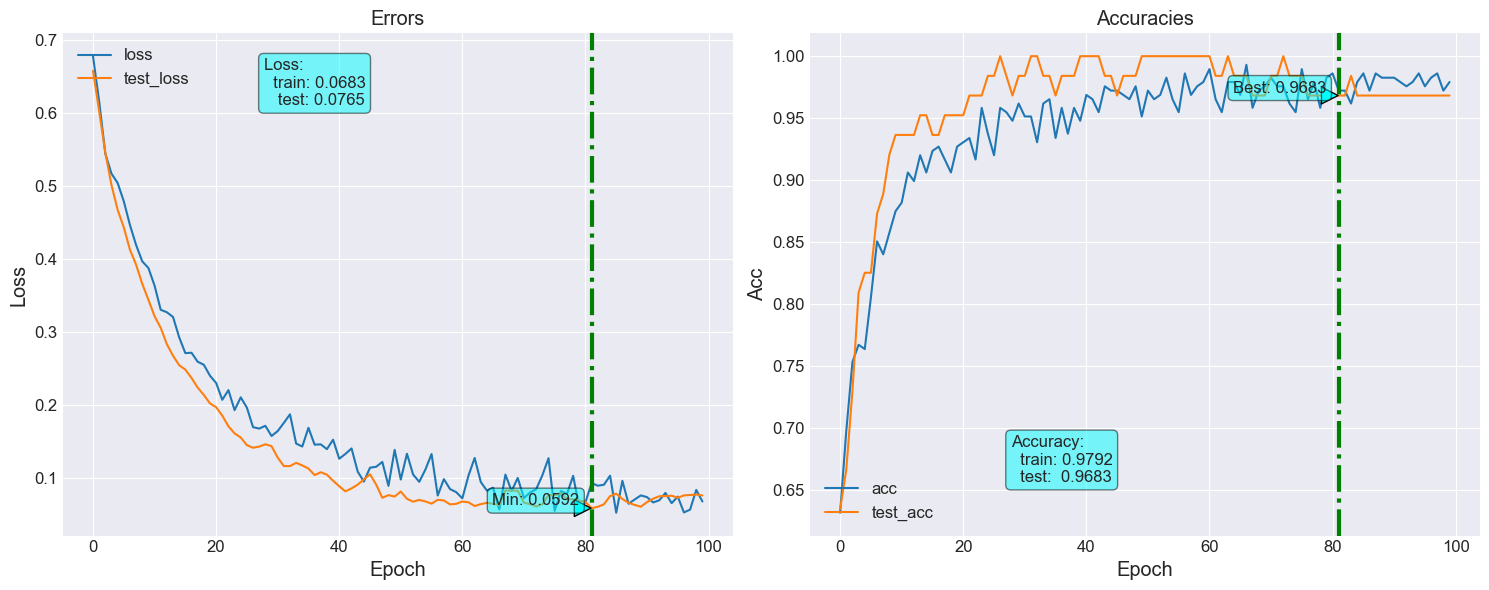

In [16]:
fn_plot_torch_hist(loss_df)